# Baseline Model

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import os
from pprint import pprint
import io
from datetime import timedelta
from importlib import reload
import adalib
from pylab import rcParams
%matplotlib inline
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
import pandas as pd
import math
from statsmodels.tsa.api import Holt
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import (
    plot_cross_validation_metric,
    plot_forecast_component,
)

## Acquire

In [2]:
df = pd.read_csv('precipitation_totals.csv')

In [3]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [4]:
df.head()

,DATE,Total
0,1893-01-01,0.11
1,1893-01-02,0.11
2,1893-01-03,0.11
3,1893-01-04,0.11
4,1893-01-05,0.11


## Set index

In [5]:
df["DATE"] = pd.to_datetime(df['DATE'])

In [6]:
df = df.set_index('DATE')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45304 entries, 1893-01-01 to 2019-05-16
Data columns (total 1 columns):
Total    45304 non-null float64
dtypes: float64(1)
memory usage: 707.9 KB


## Summarize

In [8]:
adalib.summarize(df)

RANDOM SAMPLE OF 10
            Total
DATE             
1939-02-18  0.100
1986-04-09  0.000
1976-03-30  0.010
1930-04-13  0.000
1944-12-05  2.020
1909-01-18  0.000
1937-05-22  0.000
1996-07-29  0.000
1909-01-19  0.000
1911-03-24  0.075

SHAPE: (45304, 1)

DESCRIPTION
              Total
count  45304.000000
mean       0.090535
std        0.303768
min        0.000000
25%        0.000000
50%        0.000000
75%        0.018333
max        7.915000

INFORMATION
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45304 entries, 1893-01-01 to 2019-05-16
Data columns (total 1 columns):
Total    45304 non-null float64
dtypes: float64(1)
memory usage: 707.9 KB

Total:
(-0.00892, 0.792]    43890
(0.792, 1.583]        1015
(1.583, 2.375]         264
(2.375, 3.166]          84
(3.166, 3.958]          31
(3.958, 4.749]           8
(4.749, 5.541]           9
(5.541, 6.332]           1
(6.332, 7.124]           1
(7.124, 7.915]           1
Name: Total, dtype: int64




In [9]:
df.head()

,Total
DATE,
1893-01-01,0.11
1893-01-02,0.11
1893-01-03,0.11
1893-01-04,0.11
1893-01-05,0.11


## Train/Test Split

In [10]:
train = df[:"2000-01"].resample("Y").agg('mean')
test = df["2000-02":].resample("Y").agg('mean')

In [11]:
print("Observations: %d" % (len(train.values) + len(test.values)))
print("Training Observations: %d" % (len(train)))
print("Testing Observations: %d" % (len(test)))

Observations: 128
Training Observations: 108
Testing Observations: 20


In [12]:
pd.concat([train.head(3), train.tail(3)])

,Total
DATE,
1893-12-31,0.107247
1894-12-31,0.223795
1895-12-31,0.304068
1998-12-31,0.107205
1999-12-31,0.051443
2000-12-31,0.028710


In [13]:
pd.concat([test.head(3), test.tail(3)])

,Total
DATE,
2000-12-31,0.110806
2001-12-31,0.103763
2002-12-31,0.144621
2017-12-31,0.082476
2018-12-31,0.116901
2019-12-31,0.078355


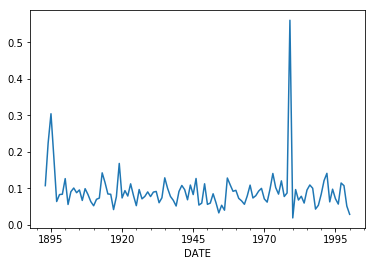

In [14]:
train.Total.plot()

Three outlier values will be removed for better accuracy in predicting.

In [15]:
train[train.Total > 0.5]

,Total
DATE,
1979-12-31,0.56


In [16]:
train = train[train.Total < 0.5]

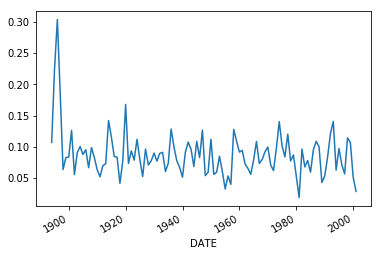

In [17]:
train.Total.plot()

In [18]:
train[train.Total > 0.2]

,Total
DATE,
1894-12-31,0.223795
1895-12-31,0.304068


In [19]:
train = train[train.Total < 0.2]

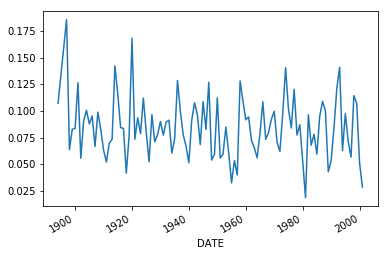

In [20]:
train.Total.plot()

# Modeling

In [21]:
def plot_data_and_predictions(train, test, predictions, label):
    plt.figure(figsize=(10, 8))

    plt.plot(train,label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label=label, linewidth=5)

    plt.legend(loc='best')
    plt.show()


def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(train, test, predictions, actual, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train, label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)
        plt.title(f"{train.name}")

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(f"{train.name}\n{label}")

    plt.legend(loc='best')
    plt.show()

## Holt's Linear Model

In [53]:
def ts_holt(train, test, **kwargs):
    yhat = pd.DataFrame(dict(actual=test))
    sm.tsa.seasonal_decompose(train, freq=30).plot()
    result = sm.tsa.stattools.adfuller(train)
    plt.show()
    
    holt = Holt(train).fit(**kwargs)
    
    yhat["holt_linear"] = holt.forecast(test.shape[0])
    
    plot_and_eval(train, test, yhat.holt_linear, test)
    
    return holt

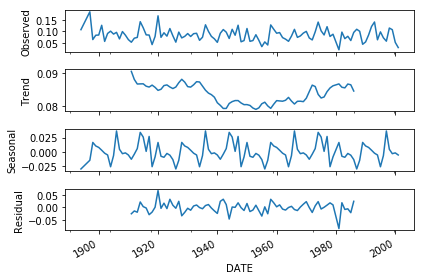

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

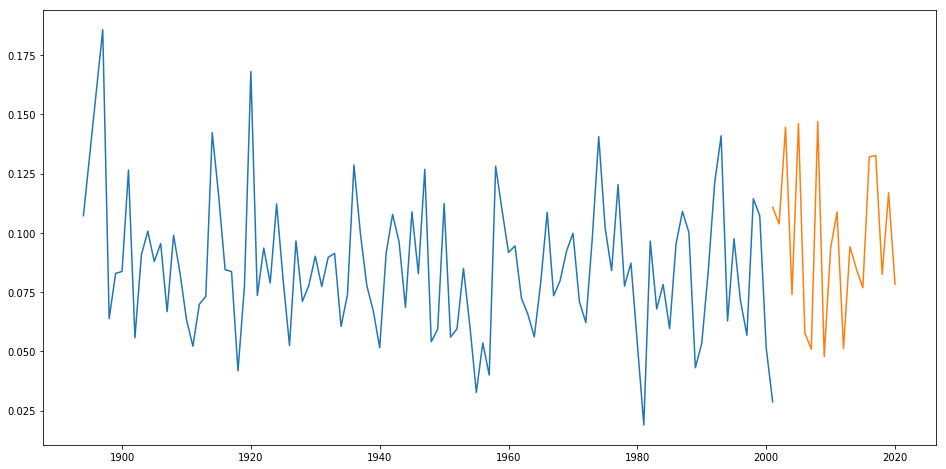

In [54]:
ts_holt(train['Total'], test['Total'], smoothing_level=0.2, smoothing_slope=0.1)

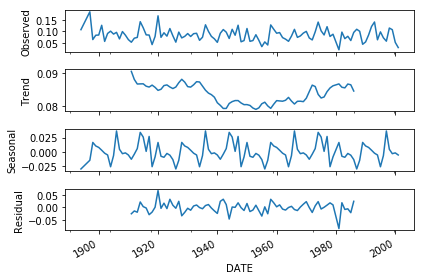

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

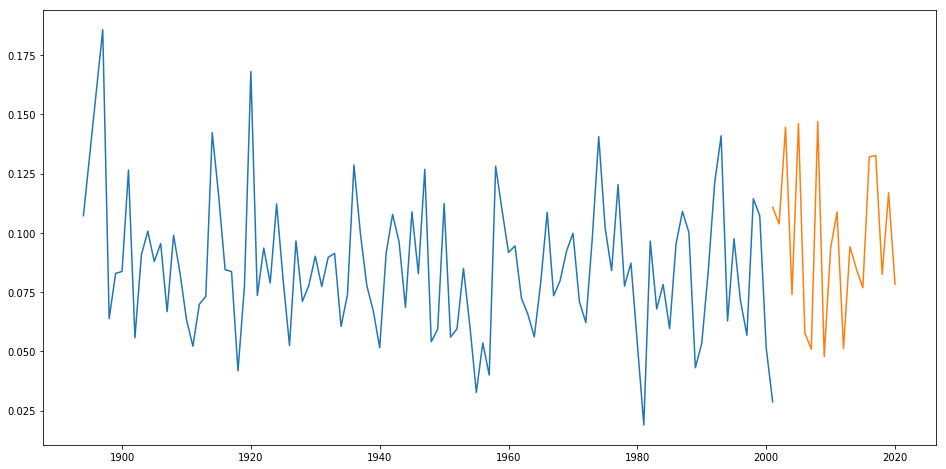

In [65]:
model = ts_holt(train['Total'], test['Total'])
df_forecast['Total'] = model.predict(df_forecast.index[0], df_forecast.index[-1])

# df_forecast.round(2).to_csv("missing_weeks_forecast.csv")

## Aggregating totals by year 

In [83]:
dfp = df.resample('Y').aggregate(np.mean)

In [84]:
dfp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127 entries, 1893-12-31 to 2019-12-31
Freq: A-DEC
Data columns (total 1 columns):
Total    127 non-null float64
dtypes: float64(1)
memory usage: 2.0 KB


In [86]:
dfp.head()

,Total
DATE,
1893-12-31,0.107247
1894-12-31,0.223795
1895-12-31,0.304068
1896-12-31,0.185724
1897-12-31,0.063822


In [89]:
dfp = dfp[dfp.Total < 0.2]

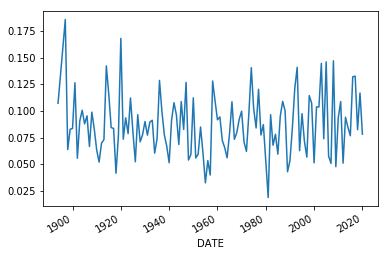

In [91]:
dfp.Total.plot()

## Prophet

In [96]:
def ts_prophet(series, periods, horizon, cap=None, floor=None, **kwargs):
    df = pd.DataFrame()
    df["y"] = series
    df["ds"] = series.index
    if cap is not None:
        df["cap"] = cap
    if floor is not None:
        df["floor"] = floor
    
    plt.figure(figsize=(16, 6))
    plt.title(series.name)
    sns.lineplot(df.ds, df.y)
    plt.show()
    
    m = Prophet(**kwargs)
    Prophet()
    m.fit(df)
    
    future = m.make_future_dataframe(periods)
    if cap is not None:
        future["cap"] = cap
    if floor is not None:
        future["floor"] = floor
    
    forecast = m.predict(future)
    
    fig1 = m.plot(forecast)
    plt.show()
    fig2 = m.plot_components(forecast)
    plt.show()
    
    df_cv = cross_validation(m, horizon)
    
    df_p = performance_metrics(df_cv, rolling_window=1)
    
    fig3 = plot_cross_validation_metric(df_cv, metric="rmse")
    plt.show()
    
    return forecast, df_cv, df_p

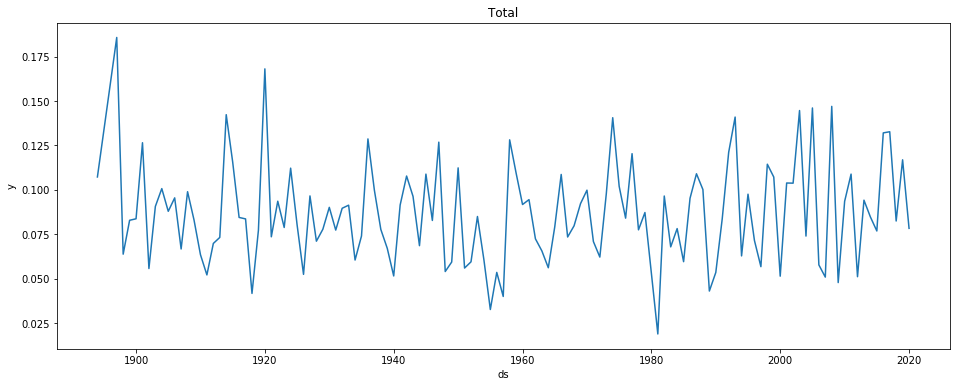

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


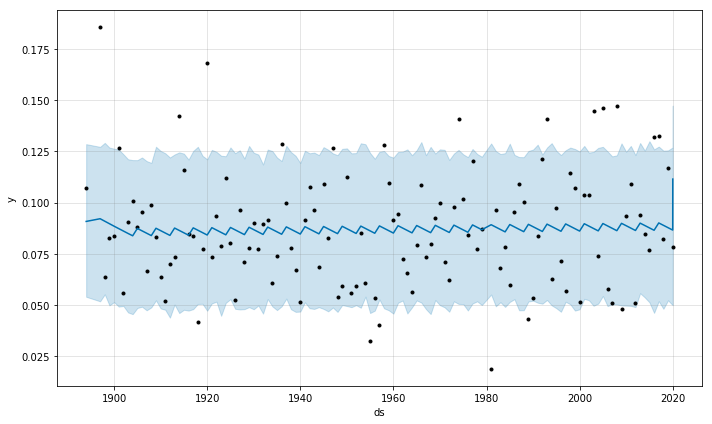

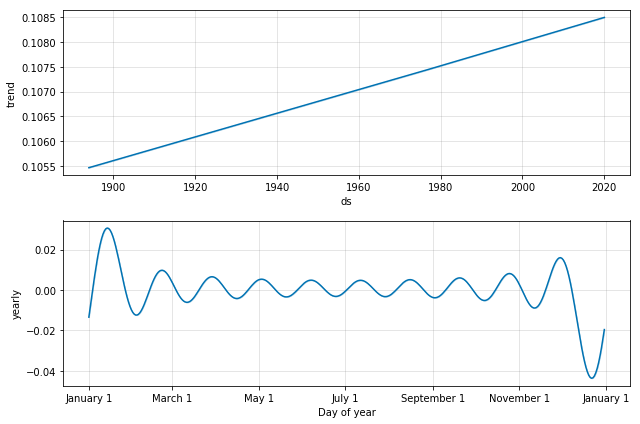

INFO:fbprophet:Making 123 forecasts with cutoffs between 1896-07-04 00:00:00 and 2019-07-04 00:00:00


Exception: Less than two datapoints before cutoff. Increase initial window.

In [102]:
_, _, df_p = ts_prophet(dfp['Total'], 5, "180 days", daily_seasonality=False)
print(df_p)

In [103]:
rd = pd.read_csv('san-antonio_reservoir_data.csv')

In [108]:
rd = rd[['date', 'reservoir_storage']]

In [111]:
rd["date"] = pd.to_datetime(rd['date'])

In [113]:
rd = rd.set_index('date')

In [126]:
rd.index.min()

Timestamp('1997-08-09 00:00:00')

In [130]:
df_prcp = df['1997-08-09':]

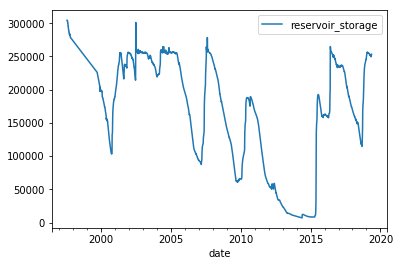

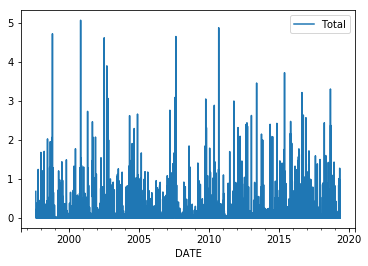

In [138]:
rd.plot()
df_prcp.plot()
plt.show()

## Prophet: 1997-2019 Precipitation, Reservoir Storage 

In [ ]:
_, _, df_p = ts_prophet(dfp['Total'], 5, "180 days", daily_seasonality=False)
print(df_p)